In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso as MVN
from distributions import log_prob_banana as log_p
from samplers import stams_mvn_hmc
import matplotlib.pyplot as plt
from util import ess
import time
from pathlib import Path
%matplotlib inline

For visualization purposes, make a discrete grid of x, y and compute the $p(x)$ density on it

In [2]:
x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

Run HMC over $\theta$ for a variety of different $\lambda_{KL}$ values

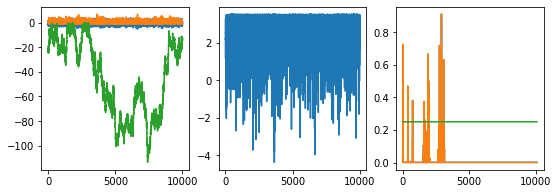

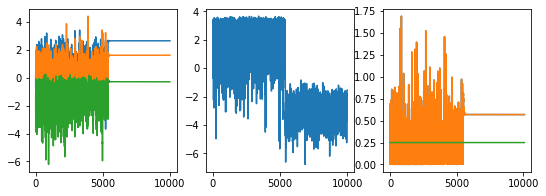

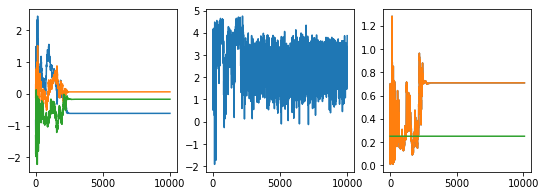

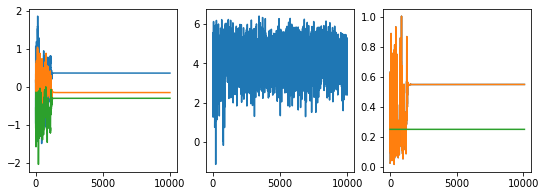

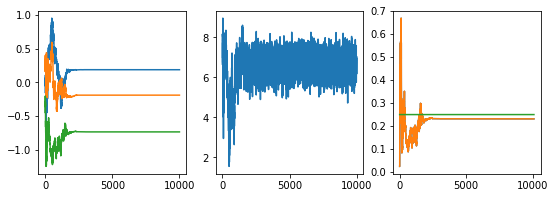

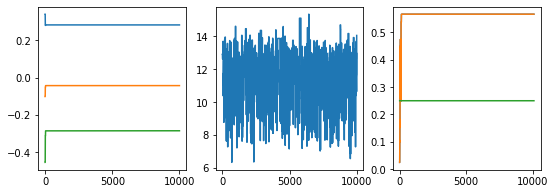

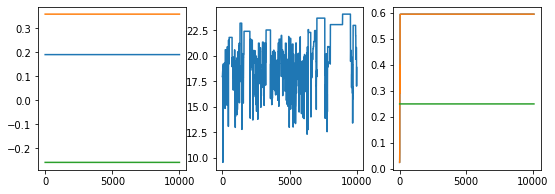

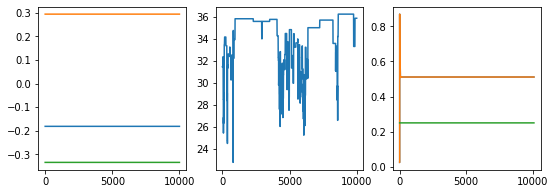

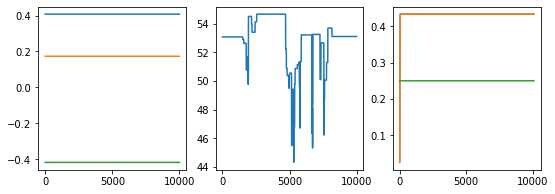

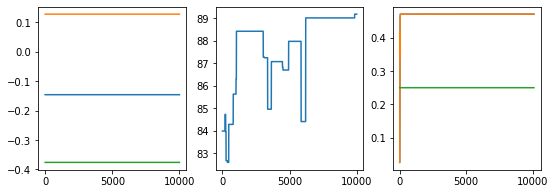

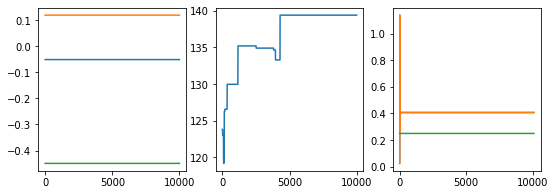

In [3]:
lambdas = torch.logspace(0, 2, 11)
results = []
qi = MVN.new_random(d=2)
for i, l in enumerate(lambdas):
    save_file = Path('results') / f"mi_kl_hmc_lam={l.item():.3f}.dat"
    if save_file.exists():
        data = torch.load(save_file)
    else:
        data = {'results': stams_mvn_hmc(log_p, lam_kl=l, q_init=qi, n_samples=10000)}
        torch.save(data, save_file)
    results.append(data['results'])
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    plt.plot(data['results']['samples'])
    plt.subplot(1,3,2)
    plt.plot(data['results']['log_psi'])
    plt.subplot(1,3,3)
    plt.plot(data['results']['masses'])

Inspect some metadata like acceptance ratio and effective sample size per $\lambda$

TODO - run a few chains and use rhat for convergence tests

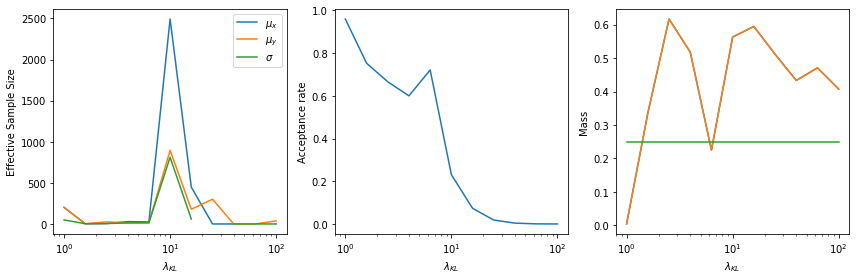

In [4]:
ess_values = torch.zeros(len(lambdas), results[0]['samples'].size(1))
mass_values = torch.zeros(len(lambdas), results[0]['samples'].size(1))
for i, (l, r) in enumerate(zip(lambdas, results)):
    s = r['samples']
    s[:,-1] = s[:,-1].exp()
    ess_values[i, :] = ess(s)
    mass_values[i, :] = r['masses'].mean(dim=0)

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].semilogx(lambdas, ess_values)
ax[0].set_xlabel(r'$\lambda_{KL}$')
ax[0].legend([r'$\mu_x$', r'$\mu_y$', r'$\sigma$'])
ax[0].set_ylabel('Effective Sample Size')

ax[1].semilogx(lambdas, [r['accept'] for r in results])
ax[1].set_xlabel(r'$\lambda_{KL}$')
ax[1].set_ylabel('Acceptance rate')

ax[2].semilogx(lambdas, mass_values)
ax[2].set_xlabel(r'$\lambda_{KL}$')
ax[2].set_ylabel('Mass')

fig.tight_layout()

Compute $E[KL]$ and Stams-approximation to $MI$ for each $\lambda$

In [5]:
ekl_values = torch.zeros(lambdas.size())
mi_values = torch.zeros(lambdas.size())

def 

for i, (l, r) in enumerate(zip(lambdas, results)):
    # TODO
    ...

NameError: name 'm_grid' is not defined

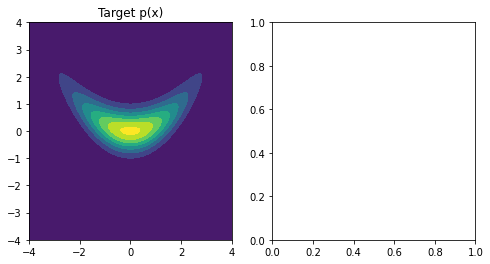

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].contourf(xx, yy, p_grid, origin='lower', vmin=0., vmax=p_grid.max())
ax[0].set_title('Target p(x)')
ax[1].contourf(xx, yy, m_grid, origin='lower', vmin=0.)
ax[1].set_title(f'm(x) with {n_samples} components, $\lambda_{{KL}}={lambda_kl}$')